In [1]:
# first set up the and run the kafka server also install kafka-python. The commands can be found in 'kakfa commands.txt'
from kafka import KafkaAdminClient
from kafka.admin import NewTopic
from time import sleep
bootstrap_servers = "38.80.153.61:31759"

# Create an instance of KafkaAdminClient
admin_client = KafkaAdminClient(
    bootstrap_servers=bootstrap_servers,  # Update with your Kafka broker(s)
    client_id='my_client'
)

topic_name_start = '3DOF_start_producing_data'
# topic_name_2 = '3DOF_stop_producing_data'

num_partitions = 1 
replication_factor = 1
topic_configs = {"retention.ms": str(600000), # all messages that are older than 10 min in the topic get deleted
                 "retention.bytes": str(int(100e6)), #when the messages in the topic exide 100 MB old messages get deleted 
                 'max.message.bytes': str(int(5e6))} #max allowed size in MB of each message set to 5MB 


try:
    topic_start = NewTopic(name=topic_name_start, num_partitions=num_partitions,
                            replication_factor=replication_factor,
                            topic_configs=topic_configs)
    # topic_2 = NewTopic(name=topic_name_1, num_partitions=num_partitions,
    #                         replication_factor=replication_factor,
    #                         topic_configs=topic_configs)

    admin_client.create_topics(new_topics=[topic_start])
    print(f'created {[topic_name_start]}')
except:
    print(f'topic {[topic_name_start]} already existed')
    admin_client.delete_topics(topics=[topic_name_start]); sleep(0.2) # topic get deleted asychronusly have to whait for changes to take affect
    topic_start = NewTopic(name=topic_name_start, num_partitions=num_partitions,
                            replication_factor=replication_factor,
                            topic_configs=topic_configs)

    # admin_client.create_topics(new_topics=[topic_start]) if consumer in server is running it creates the topic each time it tries to read it if it dosent already exist
    print(f'deleted old and created new{[topic_name_start]}')


# List all topics
topics = admin_client.list_topics()
print("Topics:", topics)



from kafka import KafkaProducer
producer = KafkaProducer(bootstrap_servers=bootstrap_servers)




topic ['3DOF_start_producing_data'] already existed
deleted old and created new['3DOF_start_producing_data']
Topics: ['3DOF', '3DOF_start_producing_data']


In [2]:
from PIL import Image
import utils
import torch
import numpy as np 
from matplotlib import pyplot as plt

sat_map_path = '../../../datasets/Ford/2017-08-04/V2/Log4/SatelliteMaps_18/42.32144438527925_-83.23340638391272.png'
sat_map = Image.open(sat_map_path).convert('RGB')
sat_map = np.array(sat_map)
# meters = 112.6
# pixels = meters / test_set.meters_per_pixel
pixels = 512 
sat_map_center = sat_map.shape[0]//2
sat_map = sat_map[sat_map_center-pixels//2:sat_map_center+pixels//2, sat_map_center-pixels//2:sat_map_center+pixels//2]
sat_map = sat_map.astype(np.float32)/255.0
sat_map = np.flip(sat_map, axis = -1).copy()

In [3]:
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import cv2

def get_corr_map(net, sat_img_norot_notran):
    '''
    in model ford self.return_for_presentation must be uncommented
    '''
    uncertainty_map = net.return_for_presentation[0]     #torch.Size([1, 1, 256, 256])         
    grd2sat_proj_feat = net.return_for_presentation[1]    #torch.Size([1, 64, 256, 256])
    sat_feat_list, _ = net.SatFeatureNet(sat_img_norot_notran)
    sat_feat = sat_feat_list[2] #torch.Size([1, 64, 256, 256])


    with torch.no_grad():
        g2s_feat = F.normalize(grd2sat_proj_feat.reshape(1,-1)).reshape(1,64,256,256)
        s_feat = sat_feat.reshape(1, -1, 256, 256) # [B, C, H, W]->[1, B*C, H, W]

        corr = F.conv2d(sat_feat, g2s_feat, padding=128, groups=1)[0]
        corr = corr[:, :256, :256]
        denominator = F.avg_pool2d(sat_feat.pow(2), (256, 256), stride=1, divisor_override=1)
        denominator = torch.sum(denominator, dim=1) * uncertainty_map[:, 0]
        denominator = torch.maximum(torch.sqrt(denominator), torch.ones_like(denominator) * 1e-6) 
        corr = 2 - 2 * corr / denominator

        corr.shape
        corr = (corr - corr.min())/(corr.max() - corr.min())
        corr = 1-corr
        corr = corr **3
        corr = corr.permute([1,2,0]).cpu().numpy().copy()
        corr = np.concatenate((np.zeros_like(corr), np.zeros_like(corr), corr), axis=2)

        return corr
    
def calculate_tranjectories(g_lats, g_lons, gt_shift_v_meters, gt_shift_u_meters, pred_shift_v_meters, pred_shift_u_meters, yaws):
    y, x = utils.gps2meters_torch(torch.tensor(g_lats).cpu(), torch.tensor(g_lons).cpu(), torch.tensor(g_lats[0]).cpu(), torch.tensor(g_lons[0]).cpu())
    x = -x ;y = -y

    xy_shift_gt = torch.stack((torch.tensor(gt_shift_v_meters), torch.tensor(gt_shift_u_meters)))
    xy_shift_pred = torch.stack((torch.tensor(pred_shift_v_meters), torch.tensor(pred_shift_u_meters)))
    xy_error = xy_shift_gt - xy_shift_pred

    yaws = torch.tensor(yaws) 
    yaws_rad = (yaws * torch.pi / 180.0) 

    row_1 = torch.stack([torch.cos(yaws_rad), torch.sin(yaws_rad)], dim =1).unsqueeze(1)
    row_2 = torch.stack([-torch.sin(yaws_rad), torch.cos(yaws_rad)], dim =1).unsqueeze(1)
    rot_mat = torch.concat([row_1,row_2], dim=1)

    xy_shift_gt_new = rot_mat @ xy_shift_gt.T.unsqueeze(-1)
    xy_shift_gt_new = xy_shift_gt_new.squeeze(-1).T
    xy_error_new = rot_mat @ xy_error.T.unsqueeze(-1)
    xy_error_new = xy_error_new.squeeze(-1).T

    traj_gt = torch.stack((x,y))
    traj_gps = traj_gt + xy_shift_gt_new
    traj_net = traj_gt + xy_error_new

    return traj_gt, traj_gps, traj_net, xy_shift_gt_new, xy_error_new

def tranjectories2image(trajctories_1, trajctories_2, trajctories_3, image):
    
    image_size = image.shape[0]
    image_meters = 112.6
    image_center = image_size//2
    pixelspermeter = image_size/image_meters

    trajctories_1_pixels = trajctories_1 * pixelspermeter + image_center; trajctories_1_pixels = trajctories_1_pixels.type(torch.int64)
    trajctories_2_pixels = trajctories_2 * pixelspermeter + image_center; trajctories_2_pixels = trajctories_2_pixels.type(torch.int64)
    trajctories_3_pixels = trajctories_3 * pixelspermeter + image_center; trajctories_3_pixels = trajctories_3_pixels.type(torch.int64)

    # image[trajctories_1_pixels[0], trajctories_1_pixels[1], :] = 0

    cv2.circle(image, (trajctories_1_pixels[1, -1].item(), trajctories_1_pixels[0, -1].item()), radius=2, color=(0, 0, 255), thickness=2)
    cv2.circle(image, (trajctories_2_pixels[1, -1].item(), trajctories_2_pixels[0, -1].item()), radius=2, color=(255, 0, 0), thickness=2)
    cv2.circle(image, (trajctories_3_pixels[1, -1].item(), trajctories_3_pixels[0, -1].item()), radius=2, color=(0, 255, 255), thickness=2)

    return image

def load_satelite_image(sat_map_path, sat_map_side_length):
    sat_map = Image.open(sat_map_path).convert('RGB')

In [4]:
from kafka import KafkaProducer, KafkaConsumer, TopicPartition
import msgpack
import simplejpeg



def dict_to_bytes(data_dict):
    return msgpack.packb(data_dict, use_bin_type=True)


def bytes_to_dict(json_str):
    return msgpack.unpackb(json_str, raw=False)


def encode_pytorch_image(img):
    """
    Takes a pytorch tensor of shape (3,H,W) and encodes it to bytes, jpeg compression is used 
    img is float32 and values are in range (0,1)
    """
    img_numpy = img * 255.0 
    img_numpy = torch.permute(img_numpy, (1,2,0)).contiguous()
    img_numpy = img_numpy.to(torch.uint8).numpy()
    grd_img_bytes = simplejpeg.encode_jpeg(img_numpy)

    return grd_img_bytes

def decode_pytorch_image(img_bytes):
    """
    Takes an encoded pytorch images that is in the form of bytes and decodes it 
    return tensor of shape (3,H,W)
    """
    img_numpy = simplejpeg.decode_jpeg(img_bytes)
    img_torch = torch.tensor(img_numpy, dtype=torch.float32) / 255.0
    img_torch = torch.permute(img_torch, [2,0,1]).contiguous()

    return img_torch

topic_name = '3DOF'

producer = KafkaProducer(bootstrap_servers=bootstrap_servers,
                         )

consumer_data_dataset = KafkaConsumer(#topic = topic_name,
                         bootstrap_servers=bootstrap_servers,
                         auto_offset_reset='latest', #will start consuming from the last message in the topic 
                         consumer_timeout_ms=5000 #stop consumer from waiting for messages after 5000ms of not reciving any messages 
                         )

consumer_data_gps = KafkaConsumer(#topic = topic_name,
                         bootstrap_servers=bootstrap_servers,
                         auto_offset_reset='latest', #will start consuming from the last message in the topic 
                        #consumer_timeout_ms=100000 #stop consumer from waiting for messages after 10000ms of not reciving any messages 
                         )

tp0 = TopicPartition(topic_name, 0)
tp2 = TopicPartition(topic_name, 2)

consumer_data_dataset.assign([tp0])
consumer_data_gps.assign([tp2])



images with id = 0 send to server with ip = 38.80.153.61
Corrected GPS location recived after 2.36 sec from server with ip = 38.80.153.61
avg_error_meters_gps 24.41, avg_error_meters_net 10.42



C:\Users\dimitris\AppData\Local\Temp\ipykernel_20704\4148201055.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y, x = utils.gps2meters_torch(torch.tensor(g_lats).cpu(), torch.tensor(g_lons).cpu(), torch.tensor(g_lats[0]).cpu(), torch.tensor(g_lons[0]).cpu())


images with id = 1 send to server with ip = 38.80.153.61
Corrected GPS location recived after 2.15 sec from server with ip = 38.80.153.61
avg_error_meters_gps 24.51, avg_error_meters_net 10.43

images with id = 2 send to server with ip = 38.80.153.61
Corrected GPS location recived after 2.00 sec from server with ip = 38.80.153.61
avg_error_meters_gps 24.60, avg_error_meters_net 10.47

images with id = 3 send to server with ip = 38.80.153.61
Corrected GPS location recived after 1.98 sec from server with ip = 38.80.153.61
avg_error_meters_gps 24.68, avg_error_meters_net 10.27

images with id = 4 send to server with ip = 38.80.153.61
Corrected GPS location recived after 1.86 sec from server with ip = 38.80.153.61
avg_error_meters_gps 24.74, avg_error_meters_net 11.23

images with id = 5 send to server with ip = 38.80.153.61
Corrected GPS location recived after 1.85 sec from server with ip = 38.80.153.61
avg_error_meters_gps 24.80, avg_error_meters_net 11.87

images with id = 6 send to ser

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Corrected GPS location recived after 1.62 sec from server with ip = 38.80.153.61
avg_error_meters_gps 22.54, avg_error_meters_net 3.96



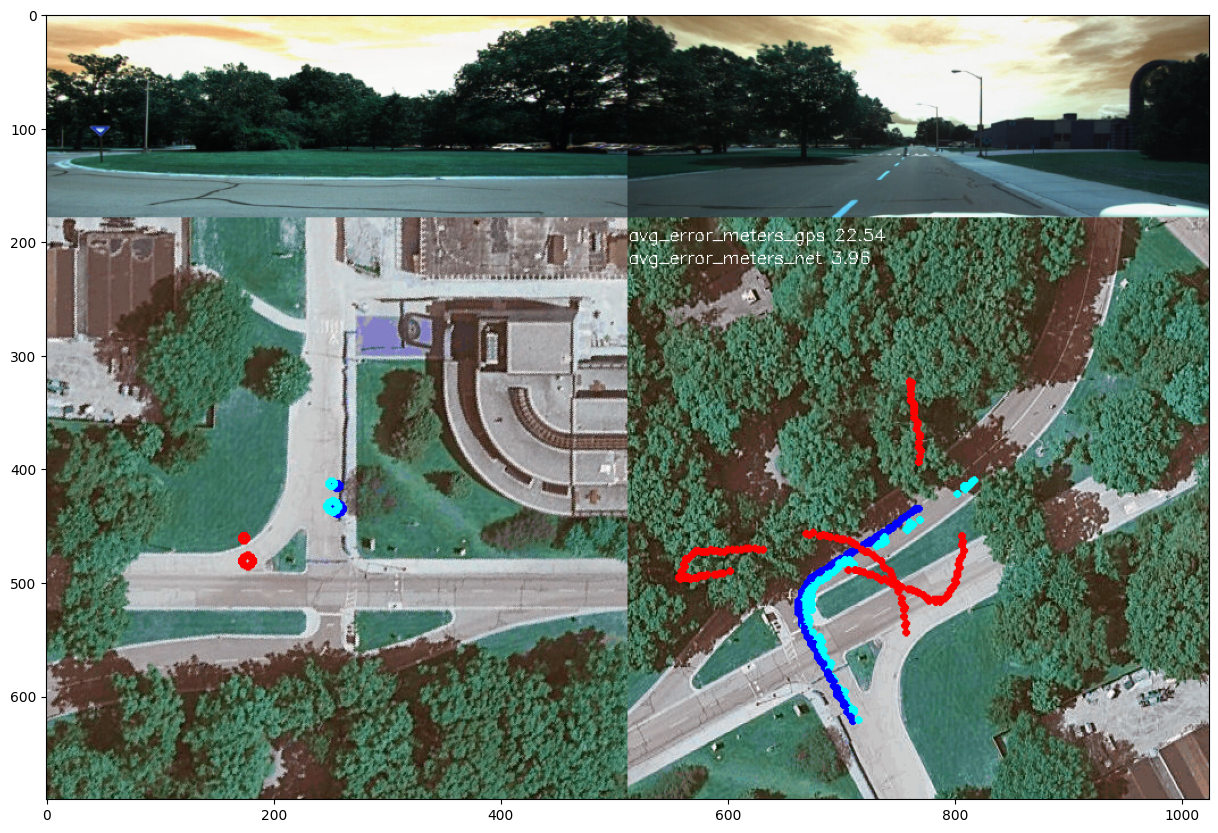

In [5]:
from IPython.display import clear_output
from io import BytesIO
from PIL import Image
import cv2
import time

# signal server to start sending image data 


s_lats = []; s_lons = []
g_lats = []; g_lons = []
gt_shift_u_meters = []; gt_shift_v_meters = []
pred_shift_u_meters = []; pred_shift_v_meters = []
yaws = []

producer.send(topic=topic_name_start, value=b'start', partition=0)
# receives the image data from a server insted of 
# having it locally and send it to the server to correct the gps location
for message in consumer_data_dataset:
    data_recived_images_bytes = message.value 
    data_recived_images = bytes_to_dict(data_recived_images_bytes)
    data_id = data_recived_images['data_id']
    # print(f'images recived for id = {data_id},', end='   ')

    data_to_send_bytes =  data_recived_images_bytes
    producer.send(topic=topic_name, value=data_to_send_bytes, partition=1)
    server_ip = bootstrap_servers.split(':')[0]
    print(f'images with id = {data_id} send to server with ip = {server_ip}')
    time_start = time.time()
    for message in consumer_data_gps:
        time_end = time.time()
        print(f'Corrected GPS location recived after {time_end-time_start:.2f} sec from server with ip = {server_ip}')
        data_recived_gps_bytes = message.value
        data_recived_gps = bytes_to_dict(data_recived_gps_bytes)
        break
    
    image_0_bytes = data_recived_images['image_0']; image_0_tensor = decode_pytorch_image(image_0_bytes).unsqueeze(0)
    image_1_bytes = data_recived_images['image_1']; image_1_tensor = decode_pytorch_image(image_1_bytes).unsqueeze(0)


    s_lat = torch.tensor(data_recived_gps['s_lat']).unsqueeze(0)
    s_lon = torch.tensor(data_recived_gps['s_lon']).unsqueeze(0)
    g_lat = torch.tensor(data_recived_gps['g_lat']).unsqueeze(0)
    g_lon = torch.tensor(data_recived_gps['g_lon']).unsqueeze(0)
    yaw = torch.tensor(data_recived_gps['yaw']).unsqueeze(0)
    gt_shift_u = torch.tensor(data_recived_gps['gt_shift_u']).unsqueeze(0)
    gt_shift_v = torch.tensor(data_recived_gps['gt_shift_v']).unsqueeze(0)
    gt_heading = torch.tensor(data_recived_gps['gt_heading']).unsqueeze(0)
    sat_img = decode_pytorch_image(data_recived_gps['sat_img']).unsqueeze(0)
    sat_img_norot_notran = decode_pytorch_image(data_recived_gps['sat_img_norot_notran']).unsqueeze(0)


    meters_per_pixel = 0.22; shift_range_meters_lon = 20; shift_range_meters_lat = 20; rotation_range = 10

#     sat_img, grd_imgs, gt_shift_u, gt_shift_v, gt_heading, grd_names, sat_img_norot_notran, s_lat, s_lon, g_lat, g_lon, yaw = [[camera.to(device) if type(camera) == torch.Tensor else camera for camera in item] if type(item)== list else item.to(device) if type(item) == torch.Tensor else item for item in data]
    s_lats.append(s_lat); s_lons.append(s_lon)
    g_lats.append(g_lat); g_lons.append(g_lon)
    yaws.append(yaw)

    pred_u = torch.tensor(data_recived_gps['pred_u'])
    pred_v = torch.tensor(data_recived_gps['pred_v'])
    pred_orien = torch.tensor(data_recived_gps['pred_orien'])

    pred_u_pixels = pred_u.cpu()/meters_per_pixel
    pred_v_pixels = pred_v.cpu()/meters_per_pixel

    
    gt_shift_u_pixels = gt_shift_u.cpu() * shift_range_meters_lon/ meters_per_pixel
    gt_shift_v_pixels = gt_shift_v.cpu() * shift_range_meters_lat/ meters_per_pixel
    
    gt_shift_u_meters.append(gt_shift_u.cpu() * shift_range_meters_lon)
    gt_shift_v_meters.append(gt_shift_v.cpu() * shift_range_meters_lat)
    pred_shift_u_meters.append(pred_u.cpu())
    pred_shift_v_meters.append(pred_v.cpu())


    # fig = plt.figure(figsize=(20, 20))
    # gs = gridspec.GridSpec(4, 2, wspace=0, hspace=0)
    # ax0 = fig.add_subplot(gs[0, 0:2])# This spans all columns in the first row
    # ax10 = fig.add_subplot(gs[1, 0])
    # ax11 = fig.add_subplot(gs[1, 1])

    sat_map_center = 512//2

    grd_imgs_plt = torch.cat((image_1_tensor, image_0_tensor), dim = -1).squeeze(0).permute([1,2,0])
    sat_img_norot_notran_plt = sat_img_norot_notran.cpu().squeeze(0).permute([1,2,0])
    # img2_plt = img2.squeeze(0).permute([1,2,0])
    # img3_plt = img3.squeeze(0).permute([1,2,0])
    sat_img_plt = sat_img.cpu().squeeze(0).permute([1,2,0])


    a = 20
    gt_theta =  -gt_heading.cpu() * rotation_range * np.pi/180
    gt_shift_u_a =  -np.sin(gt_theta) * a
    gt_shift_v_a =  -np.cos(gt_theta) * a

    pred_theta = - pred_orien.cpu() * rotation_range * np.pi/180 
    pred_shift_u_a =  -np.sin(pred_theta) * a
    pred_shift_v_a =  -np.cos(pred_theta) * a

    # print('gt position', gt_shift_u_pixels, gt_shift_v_pixels, gt_heading)
    # print('pred position', pred_u_pixels, pred_v_pixels, pred_orien)#, pred_u_pixels, pred_v_pixels)
    
    if data_id==0: zeros_right = sat_map#np.zeros_like(sat_img_norot_notran_cv2)[:,:sat_img_norot_notran_cv2.shape[1],:] 
    traj_1, traj_2, traj_3, gps_shift, net_shift = calculate_tranjectories(g_lats, g_lons, gt_shift_v_meters, gt_shift_u_meters, pred_shift_v_meters, pred_shift_u_meters, yaws)
    avg_error_meters_gps = gps_shift[0] ** 2 + gps_shift[1] **2; avg_error_meters_gps = avg_error_meters_gps.mean().item() ** 0.5
    avg_error_meters_net = net_shift[0] ** 2 + net_shift[1] **2; avg_error_meters_net = avg_error_meters_net.mean().item() ** 0.5
    print(f'avg_error_meters_gps {avg_error_meters_gps:.2f}, avg_error_meters_net {avg_error_meters_net:.2f}', end='\n\n')

    # uncomment every thing below here for visualization 
    # zeros_right = tranjectories2image(traj_1, traj_2, traj_3, zeros_right)
    # sat_img_norot_notran_cv2 = cv2.cvtColor(sat_img_norot_notran_plt.numpy().copy(), cv2.COLOR_BGR2RGB)
    # cv2.circle(sat_img_norot_notran_cv2, (sat_map_center, sat_map_center), radius=5, color=(0, 0, 255), thickness=5)
    # cv2.circle(sat_img_norot_notran_cv2, (sat_map_center, sat_map_center-a), radius=3, color=(0, 0, 255), thickness=3)
    # cv2.circle(sat_img_norot_notran_cv2, (int(sat_map_center+gt_shift_u_pixels), int(sat_map_center+gt_shift_v_pixels)), radius=5, color=(255, 0, 0), thickness=5)
    # cv2.circle(sat_img_norot_notran_cv2, (int(sat_map_center+gt_shift_u_pixels+gt_shift_u_a), int(sat_map_center+gt_shift_v_pixels+gt_shift_v_a)), radius=3, color=(255, 0, 0), thickness=3)
    # cv2.circle(sat_img_norot_notran_cv2, (int(sat_map_center+gt_shift_u_pixels-pred_u_pixels), int(sat_map_center+gt_shift_v_pixels-pred_v_pixels)), radius=5, color=(0, 255, 255), thickness=5)
    # cv2.circle(sat_img_norot_notran_cv2, (int(sat_map_center+gt_shift_u_pixels-pred_u_pixels+gt_shift_u_a-pred_shift_u_a), int(sat_map_center+gt_shift_v_pixels-pred_v_pixels+pred_shift_v_a)), radius=3, color=(0, 255, 255), thickness=3)

    # grd_imgs_cv2 = cv2.cvtColor(grd_imgs_plt.numpy().copy(), cv2.COLOR_BGR2RGB)
    # grd_imgs_cv2 = cv2.resize(grd_imgs_cv2, (grd_imgs_cv2.shape[1]//2, int(grd_imgs_cv2.shape[0]*0.7),))

    # sat_img_norot_notran_cv2 = cv2.resize(sat_img_norot_notran_cv2, (grd_imgs_cv2.shape[1]//2,)*2)


    # zeros_right_text = cv2.putText(zeros_right.copy(), text = f'avg_error_meters_gps {avg_error_meters_gps:.2f}', org=(0, 20), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(255,255,255))
    # cv2.putText(zeros_right_text, text = f'avg_error_meters_net {avg_error_meters_net:.2f}', org=(0, 40), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(255,255,255))
    # sat_img_norot_notran_cv2 = np.concatenate((sat_img_norot_notran_cv2,zeros_right_text), axis=1)
    # img = np.concatenate((grd_imgs_cv2, sat_img_norot_notran_cv2), axis=0)


    # cv2.imshow('img', img)
    # cv2.waitKey(1) 

    if data_id>160*1:break
    data_id+=1

# uncomment every thing below here for visualization 
# cv2.destroyAllWindows() 
# plt.figure(figsize=(15,15))
# plt.imshow(img)
# plt.show() 

In [6]:
# import sys 

# 3*256*1024, sys.getsizeof(image_0), len(image_0)